# Motivating examples
This document shows how SparseSC can be used in places where simple difference-in-differences can't.

## Basic setup

In [1]:
#If running from the repo and you would like to use the local pkg version uncomment the following lines, otherwise comment
import sys
import os
sys.path.insert(0, os.path.abspath('..'))

In [2]:
#Load code
import numpy as np
import random
import matplotlib.pyplot as plt
import SparseSC as SC

exec(open("./example_graphs.py").read()) #if we don't want an __init.py__

def simple_summ(fit, Y):
    print("V_pen=%s, W_pen=%s" % (fit.V_penalty, fit.weight_penalty))
    print("V=%s" % np.diag(fit.V))
    print("Treated weights: sim=%s, uns=%s, sum=%s" % (fit.sc_weights[0,49], fit.sc_weights[0,99], sum(fit.sc_weights[0,:])))
    print("Sim Con weights: sim=%s, uns=%s, sum=%s" % (fit.sc_weights[1,49], fit.sc_weights[1,99], sum(fit.sc_weights[1,:])))
    print("Uns Con weights: sim=%s, uns=%s, sum=%s" % (fit.sc_weights[51,49], fit.sc_weights[51,99], sum(fit.sc_weights[51,:])))
    Y_sc = fit.predict(Y[fit.control_units, :])
    print("Treated diff: %s" % (Y - Y_sc)[0,:])


In [3]:
#make sure the results are the same each time we run
random.seed(12345) 
np.random.seed(12345)

Setup common data parameters

In [4]:
N1,N0_sim,N0_not = 1,50,50
N0 = N0_sim + N0_not
N=N1+N0
treated_units = [0]
control_units = list(set(range(N)) - set(treated_units))
N1_sim = 50 #which ones look like the treatment
T0,T1 = 5, 5
T=T0+T1
te = np.hstack((np.zeros((1,T0)), np.full((1,T0), 2)))

## Differential Trends

In [5]:
proto_sim = np.array(range(0,T,1),ndmin=2)
proto_not = np.array(range(0,2*T,2),ndmin=2)
Y1 = proto_sim + te
Y0_sim = np.matmul(np.ones((N0_sim,1)), proto_sim)
Y0_not = np.matmul(np.ones((N0_not,1)), proto_not)
Y = np.vstack((Y1,Y0_sim,Y0_not))

Motivation: Treated unit does not look like a simple average of controls

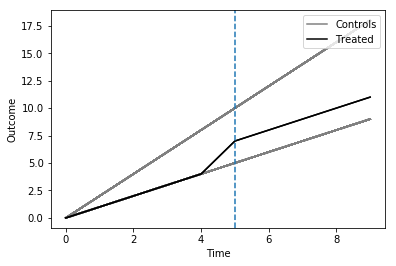

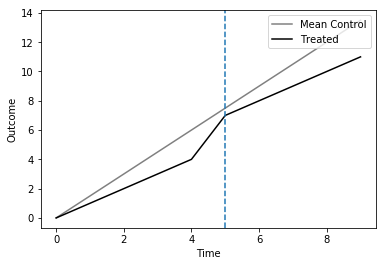

In [6]:
[raw_all, raw_means] = raw_plots(Y, treated_units, control_units, T0)
raw_all.show()
raw_means.show()

Analyze

In [7]:
#Currently the built-in joint opimization of penalties isn't great, so do two steps
ret_full = SC.estimate_effects(Y[:,:T0], Y[:,T0:], treated_units)
V_penalty = ret_full.fit.V_penalty
#simple_summ(ret_full.fit, Y)
ret = SC.estimate_effects(Y[:,:T0], Y[:,T0:], treated_units, covariate_penalties=[V_penalty], weight_penalty=0.00001)
simple_summ(ret.fit, Y)

V_pen=15259436.3697, W_pen=1e-05
V=[  0.00000000e+00   0.00000000e+00   0.00000000e+00   1.20783599e-05
   7.87932218e-05]
Treated weights: sim=0.00800005841819, uns=0.00600011683635, sum=0.700008762727
Sim Con weights: sim=0.00807275430285, uns=0.00604449850469, sum=0.697789886074
Uns Con weights: sim=0.0121539999917, uns=0.0142069898825, sum=1.30384250383
Treated diff: [  0.00000000e+00  -1.46045441e-05  -2.92090882e-05  -4.38136323e-05
  -5.84181765e-05   1.99992698e+00   1.99991237e+00   1.99989777e+00
   1.99988316e+00   1.99986856e+00]


Visualize

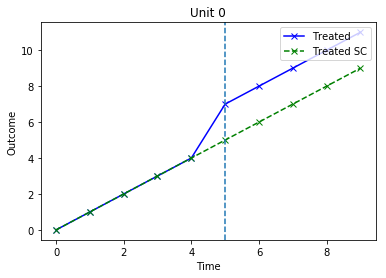

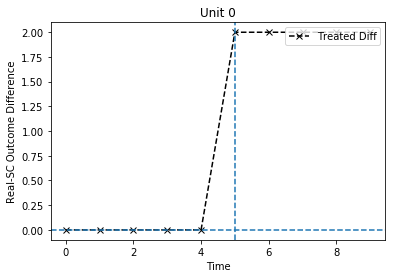

In [8]:
Y_sc = ret.fit.predict(Y[control_units, :])
[t_raw, t_diff] = te_plots(Y[0,:], Y_sc[0,:], T0)
plt.figure("t_raw")
plt.title("Unit 0")
t_raw.show()
plt.figure("t_diff")
plt.title("Unit 0")
t_diff.show()

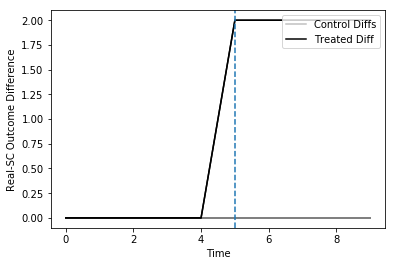

In [9]:
diffs = Y - Y_sc
diffs_plt = diffs_plot(diffs, treated_units, control_units)
diffs_plt.show()

## Different cycles 

In [10]:
proto_sim = np.array([0,1,4,3,4,5,6,9,8,9],ndmin=2)
proto_not = np.array([0,3,2,4,3,5,4,6,5,7],ndmin=2)
Y1 = proto_sim + te
Y0_sim = np.matmul(np.ones((N0_sim,1)), proto_sim)
Y0_not = np.matmul(np.ones((N0_not,1)), proto_not)
Y = np.vstack((Y1,Y0_sim,Y0_not))

Motivation: Treated unit does not look like a simple average of controls

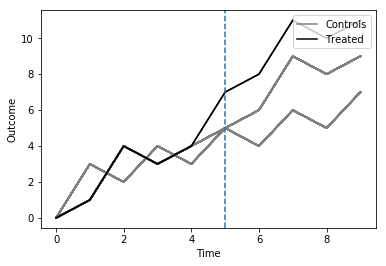

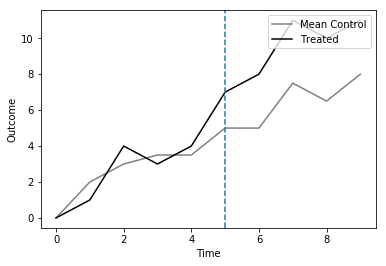

In [11]:
[raw_all, raw_means] = raw_plots(Y, treated_units, control_units, T0)
raw_all.show()
raw_means.show()

Analyze

In [12]:
#Currently the built-in joint opimization of penalties isn't great, so do two steps
ret_full = SC.estimate_effects(Y[:,:T0], Y[:,T0:], treated_units)
V_penalty = ret_full.fit.V_penalty
#simple_summ(ret_full.fit, Y)
ret = SC.estimate_effects(Y[:,:T0], Y[:,T0:], treated_units, covariate_penalties=[V_penalty], weight_penalty=0.00001)
simple_summ(ret.fit, Y)

V_pen=1948080.31767, W_pen=1e-05
V=[  0.00000000e+00   0.00000000e+00   6.28981547e-05   0.00000000e+00
   9.74555980e-06]
Treated weights: sim=0.0198101238175, uns=0.000352716792667, sum=1.00814203051
Sim Con weights: sim=0.020211068969, uns=0.000358760620626, sum=1.00828041051
Uns Con weights: sim=0.000194233162074, uns=0.0200399471325, sum=0.991669067596
Treated diff: [ 0.         -0.04341371  0.00270356 -0.04206193 -0.01493228  1.95928985
  1.9864195   1.97962924  1.98777127  1.9619934 ]


Visualize

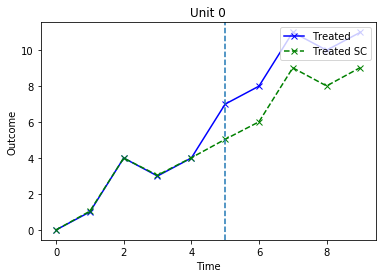

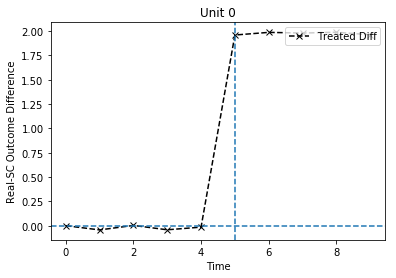

In [13]:
Y_sc = ret.fit.predict(Y[control_units, :])
[t_raw, t_diff] = te_plots(Y[0,:], Y_sc[0,:], T0)
plt.figure("t_raw")
plt.title("Unit 0")
t_raw.show()
plt.figure("t_diff")
plt.title("Unit 0")
t_diff.show()

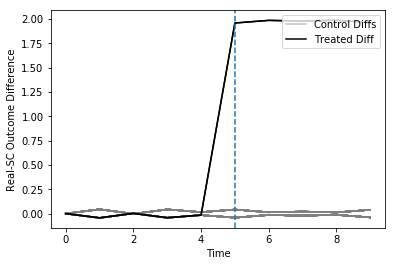

In [14]:
diffs = Y - Y_sc
diffs_plt = diffs_plot(diffs, treated_units, control_units)
diffs_plt.show()